In [43]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint


device = torch.device('cpu')
batch_time = 10
data_size =1000
batch_size =20

true_y0 = torch.tensor([[.1, 0.]]).to(device)
t = torch.linspace(0., 25., data_size).to(device)
true_A = torch.tensor([[0, 1.0], [-1.0, 0.]]).to(device)
mu = 10.


class Lambda(nn.Module):

    def forward(self, t, y):
        y_new = torch.stack([y[:,1],mu * (1-y[:,0]**2)*y[:,1]-y[:,0]],axis=1)
        return y_new


with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')



In [44]:

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)


class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return torch.stack([y[...,1],-y[...,0]],axis=-1) +  self.net(y)

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


Iter 0020 | Total Loss 0.963056


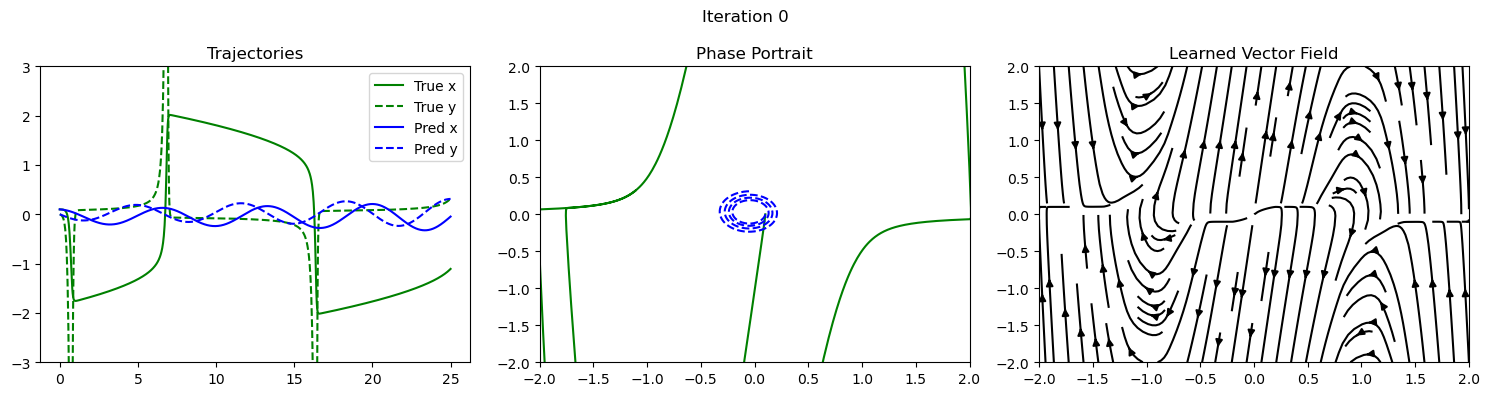

Iter 0040 | Total Loss 0.960509


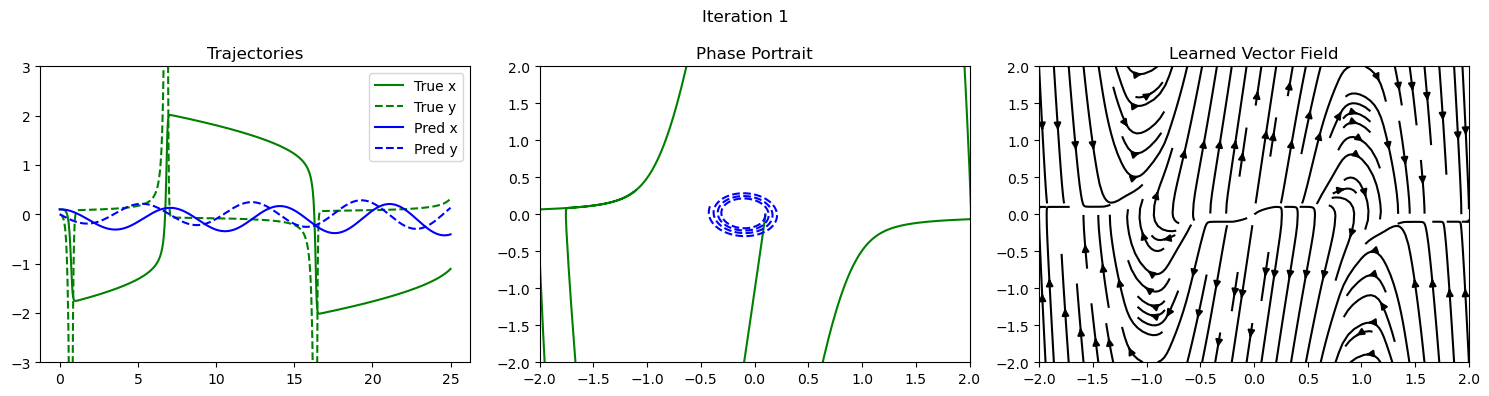

Iter 0060 | Total Loss 0.957121


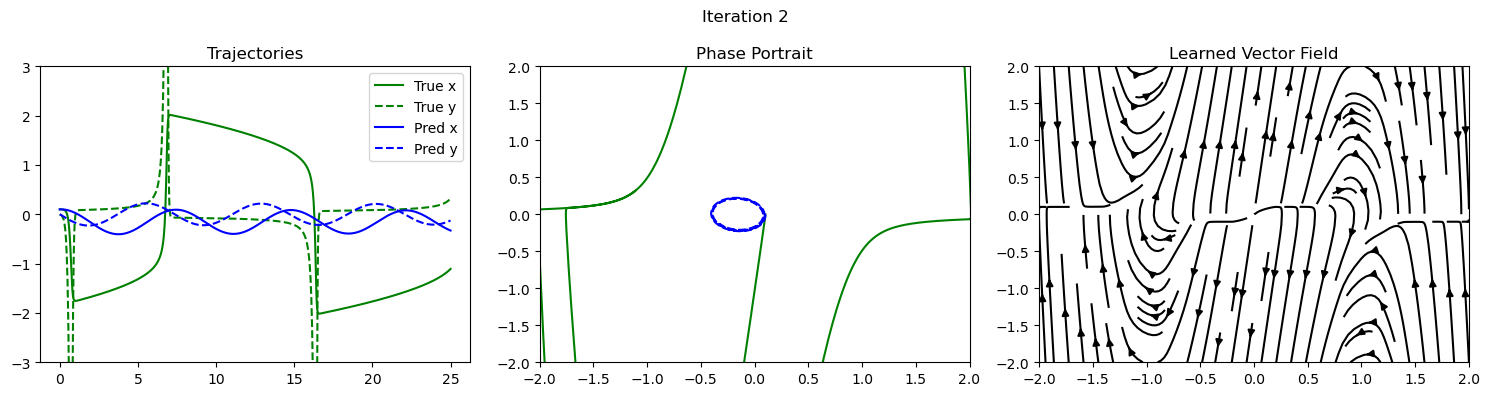

Iter 0080 | Total Loss 0.945194


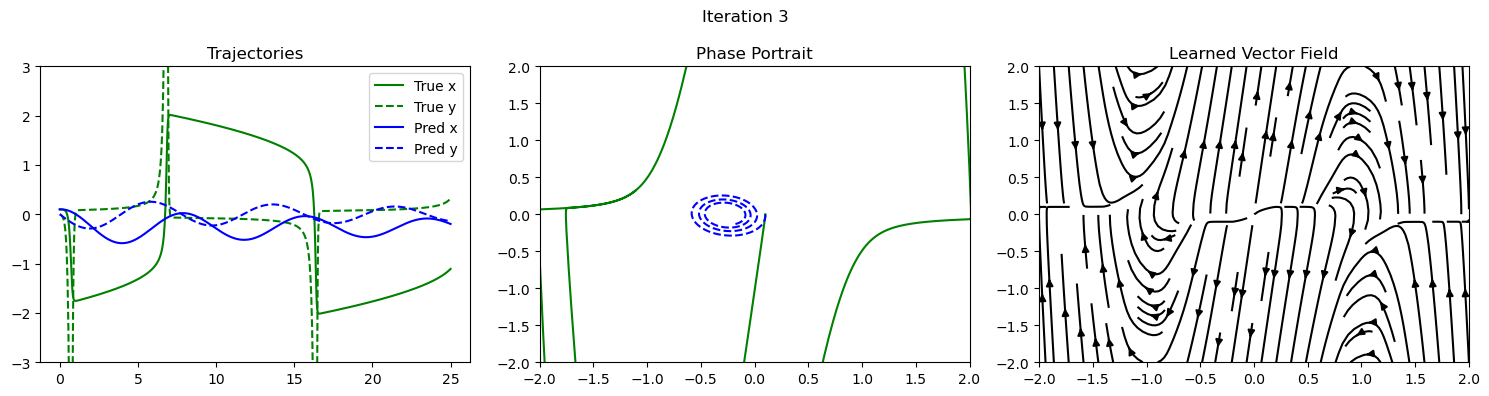

Iter 0100 | Total Loss 0.924091


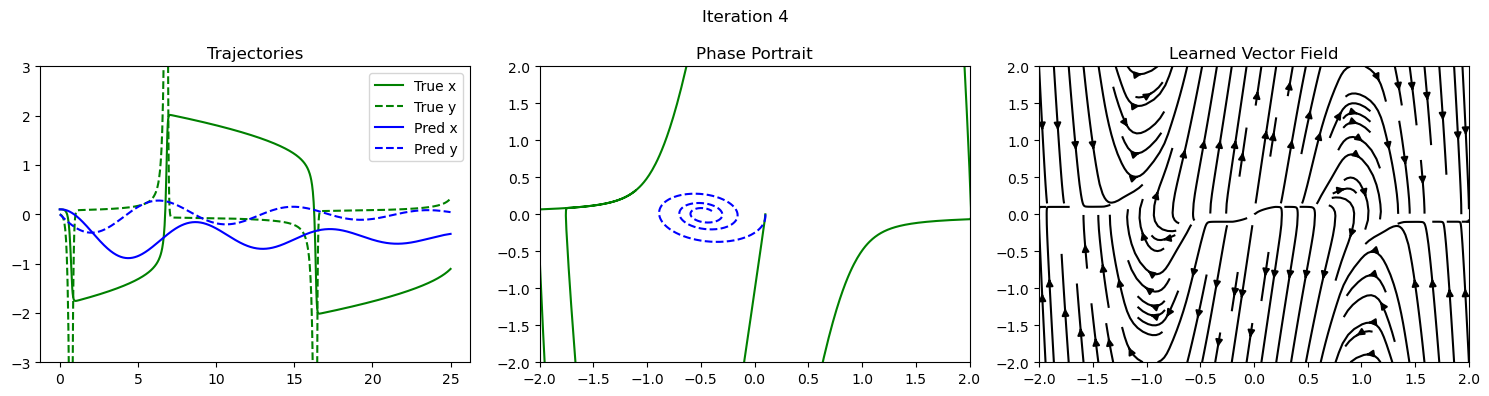

Iter 0120 | Total Loss 0.913750


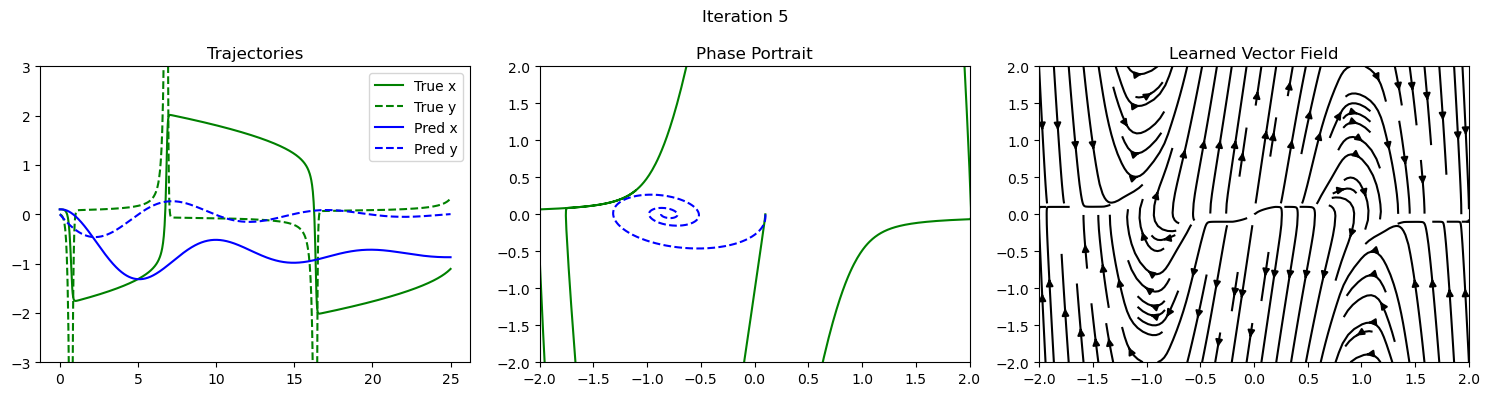

Iter 0140 | Total Loss 0.963910


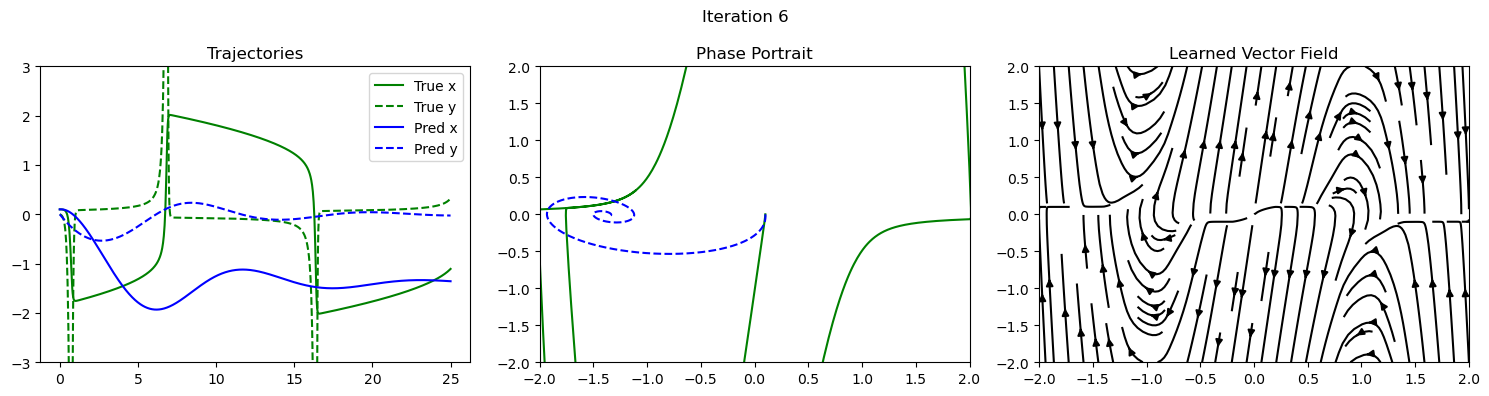

Iter 0160 | Total Loss 1.009961


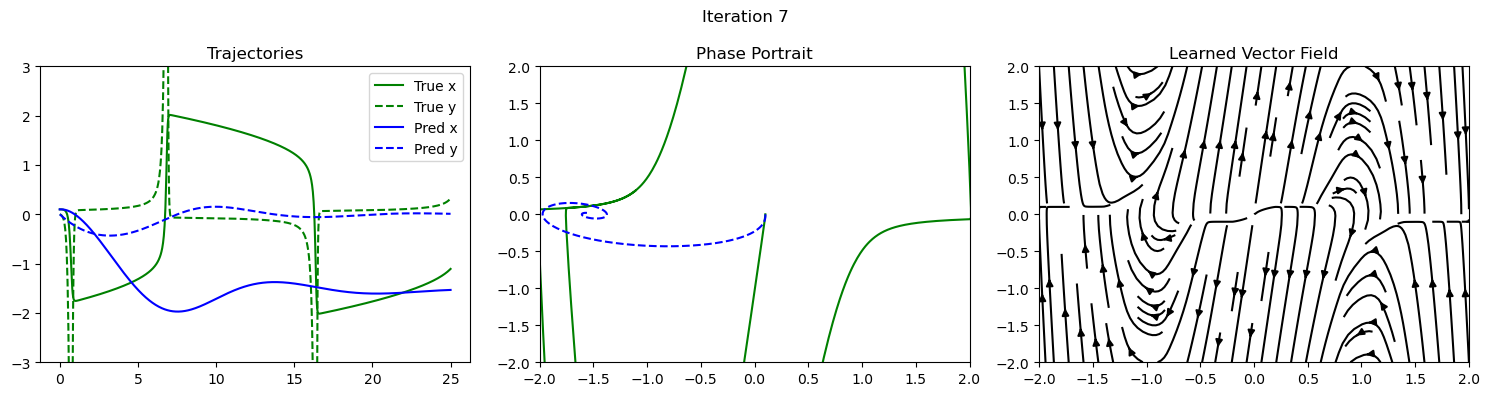

Iter 0180 | Total Loss 0.995598


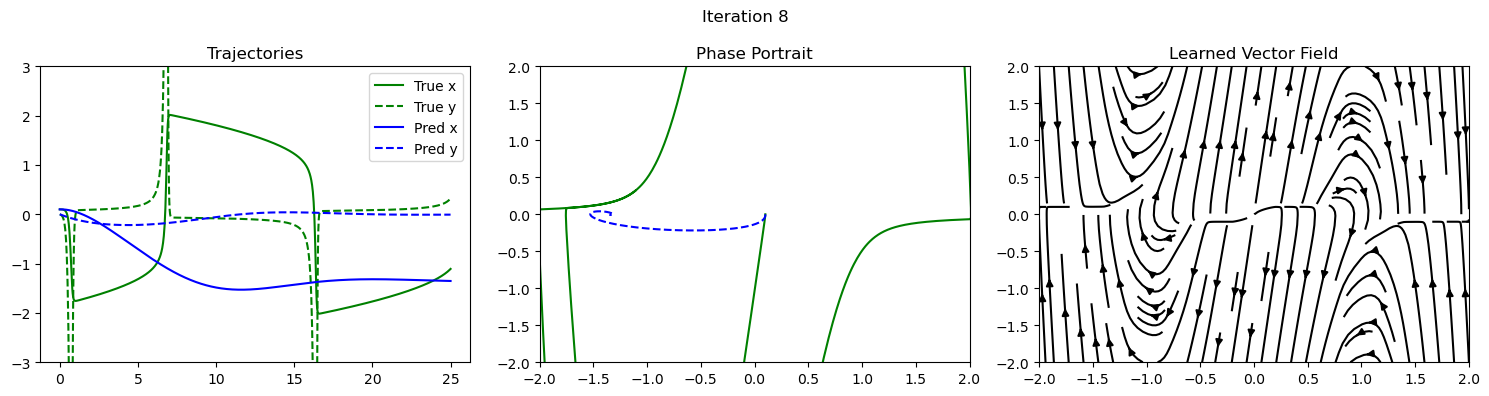

Iter 0200 | Total Loss 0.994600


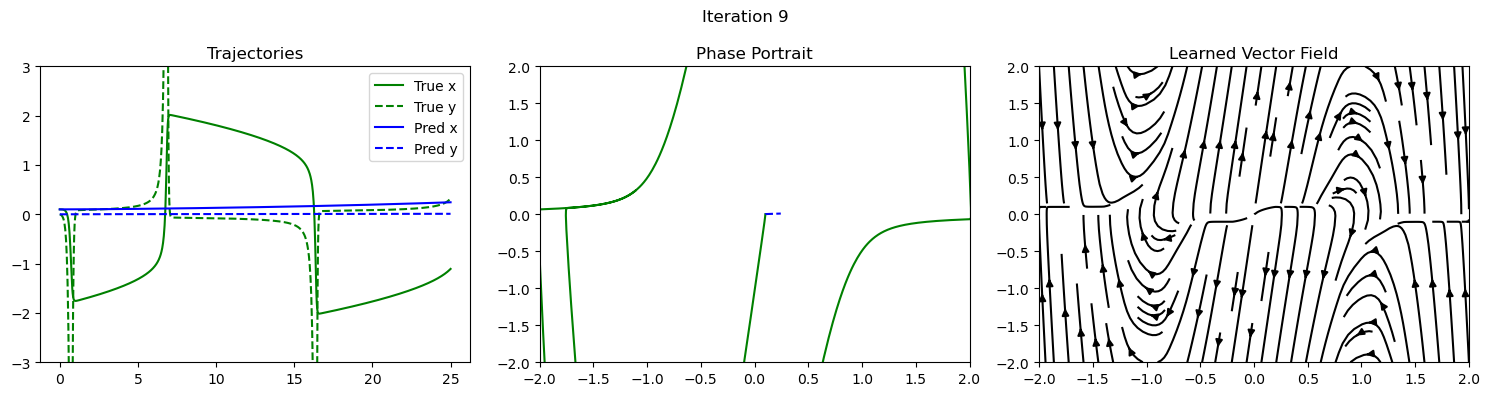

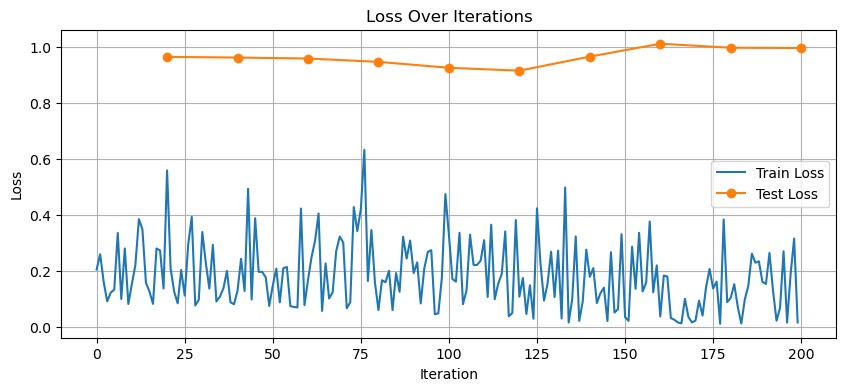

In [ ]:
niters = 1500
test_freq = 20

def visualize(true_y, pred_y, odefunc, itr):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    # Trajectories
    axes[0].plot(t.cpu(), true_y.cpu()[:, 0, 0], 'g-', label='True x')
    axes[0].plot(t.cpu(), true_y.cpu()[:, 0, 1], 'g--', label='True y')
    axes[0].plot(t.cpu(), pred_y.cpu()[:, 0, 0], 'b-', label='Pred x')
    axes[0].plot(t.cpu(), pred_y.cpu()[:, 0, 1], 'b--', label='Pred y')
    axes[0].set_title('Trajectories')
    axes[0].legend()
    axes[0].set_ylim(-3, 3)
    
    # Phase portrait
    axes[1].plot(true_y.cpu()[:, 0, 0], true_y.cpu()[:, 0, 1], 'g-')
    axes[1].plot(pred_y.cpu()[:, 0, 0], pred_y.cpu()[:, 0, 1], 'b--')
    axes[1].set_title('Phase Portrait')
    axes[1].set_xlim(-2, 2)
    axes[1].set_ylim(-2, 2)
    
    # Learned vector field
    y, x = np.mgrid[-2:2:21j, -2:2:21j]
    grid = torch.Tensor(np.stack([x, y], -1).reshape(-1, 2)).to(device)
    with torch.no_grad():
        dydt = odefunc(0, grid).cpu().numpy()
    mag = np.linalg.norm(dydt, axis=1, keepdims=True)
    dydt = dydt / (mag + 1e-6)
    dydt = dydt.reshape(21, 21, 2)
    axes[2].streamplot( x, y, dydt[:, :, 0], dydt[:, :, 1], color='black' )
    axes[2].set_xlim(-2, 2)
    axes[2].set_ylim(-2, 2)
    axes[2].set_title('Learned Vector Field')
    plt.suptitle(f'Iteration {itr}')
    plt.tight_layout()
    plt.show()
    
ii = 0

func = ODEFunc().to(device)

optimizer = optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)

loss_meter = RunningAverageMeter(0.97)

test_losses = []
all_losses = []

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t,adjoint_options={"norm": "seminorm"}).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_val = loss.item()
    all_losses.append(loss_val)
    loss_meter.update(loss_val)

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            test_losses.append((itr, loss.item()))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, Lambda(), ii)
            ii += 1

    end = time.time()
    
    
    
                
plt.figure(figsize=(10, 4))
plt.plot(all_losses, label='Train Loss')
if test_losses:
    test_iters, test_vals = zip(*test_losses)
    plt.plot(test_iters, test_vals, 'o-', label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Over Iterations')
plt.legend()
plt.grid(True)
plt.show()